<h1 style="font-size:3rem;color:orange;">Directing User Subscriptions</h1>

<h2 style="font-size:2rem;color:orange;">Data Pre-processing and Model Building</h2>

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import time
import os

### Import Data

In [2]:
df_users = pd.read_csv("../data/processed/new_app-user-data.csv")

### Data Peek

In [3]:
df_users.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,OtherScreens,SavingsScreens,CreditMonitoringScreens,CreditCardScreens,LoanScreens
0,235136,3,2,23,15,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,1
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,5,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,234192,4,16,28,40,0,0,1,0,1,...,0,0,0,0,0,6,0,3,0,1
4,51549,1,18,31,32,0,0,1,1,0,...,0,0,0,0,0,10,0,2,0,1


# Data Pre-processing

### Remove the label from the features

In [4]:
label = df_users['enrolled']
df_users = df_users.drop(columns = 'enrolled')

### Split the dataset into training and test sets

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into an 80/20 train/test ratio
X_train, X_test, y_train, y_test = train_test_split(df_users, label,
                                                    test_size = 0.2,
                                                    random_state = 42)
print(X_train.shape)
print(X_test.shape)

X_train.head()

(39701, 49)
(9926, 49)


,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked,location,Institutions,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,OtherScreens,SavingsScreens,CreditMonitoringScreens,CreditCardScreens,LoanScreens
39408,241027,3,5,39,21,0,0,1,1,0,...,0,0,0,0,0,9,0,1,0,1
46774,80501,5,3,43,13,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,0
31028,311109,1,20,29,57,0,1,0,1,0,...,0,0,0,0,0,16,0,2,0,1
36570,116866,2,2,20,8,0,0,0,1,0,...,0,0,0,0,0,4,0,0,0,0
20436,127297,4,4,41,19,0,0,0,1,0,...,0,0,0,0,0,7,0,0,0,1


### Filter model data

In [6]:
# Purge user identification, persist to associate the prediction to the user it came from 
train_identifier = X_train['user']
X_train = X_train.drop(columns = ['user'])

test_identifier = X_test['user']
X_test = X_test.drop(columns = ['user'])

Next, we selectively exclude features estimated in model building to have a high p-value 

In [7]:
drop_features = ['liked', 'Splash', 'Cycle', 'RewardDetail', 'ProfileChildren ', 'ProfileEducation', 'ProfileEducationMajor', 'ProfileJobTitle', 'SecurityModal']

# Drop the features estimated to have high p-values
X_train = X_train.drop(columns = drop_features)
X_test = X_test.drop(columns = drop_features)

### Feature Scaling

In [8]:
from sklearn.preprocessing import StandardScaler

# To normalize features
standard_scaler_X = StandardScaler()

# Scale the training & test datasets, persist results to a new dataframe
X_train2 = pd.DataFrame(standard_scaler_X.fit_transform(X_train))
X_test2 = pd.DataFrame(standard_scaler_X.transform(X_test))

# Retrieve columns for the standardized training & test sets 
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values

# Recuperate indexes 
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values

# Convert original training set into the new training set
X_train = X_train2
X_test = X_test2

X_train.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,location,Institutions,VerifyPhone,BankVerification,...,WebView,ResendToken,TransactionList,NetworkFailure,ListPicker,OtherScreens,SavingsScreens,CreditMonitoringScreens,CreditCardScreens,LoanScreens
39408,-0.015638,-1.019260,0.665530,0.034525,-0.348882,-0.456194,0.972495,-0.641867,0.961473,-0.679122,...,-0.324583,-0.114753,-0.113394,-0.090143,-0.087697,0.782567,-0.250672,0.068025,-0.284849,0.313995
46774,0.968279,-1.288261,1.034032,-0.529185,-0.348882,-0.456194,-1.028283,-0.641867,-1.040071,-0.679122,...,-0.324583,-0.114753,-0.113394,-0.090143,-0.087697,0.232221,-0.250672,-0.757110,-0.284849,-1.159691
31028,-0.999556,0.998246,-0.255724,2.571218,-0.348882,2.192051,0.972495,-0.641867,0.961473,1.472489,...,-0.324583,-0.114753,-0.113394,-0.090143,-0.087697,2.708779,-0.250672,0.893160,-0.284849,0.313995
36570,-0.507597,-1.422761,-1.084853,-0.881504,-0.348882,-0.456194,0.972495,-0.641867,0.961473,1.472489,...,-0.324583,-0.114753,-0.113394,-0.090143,-0.087697,-0.593298,-0.250672,-0.757110,-0.284849,-1.159691
20436,0.476321,-1.153761,0.849781,-0.106403,-0.348882,-0.456194,0.972495,-0.641867,-1.040071,-0.679122,...,-0.324583,-0.114753,-0.113394,-0.090143,-0.087697,0.232221,-0.250672,-0.757110,-0.284849,0.313995


# Model Building

## Training

In [9]:
# Split the training set into a 80/20 training/validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [10]:
from sklearn.linear_model import LogisticRegression

# Add 'l1' penalty (lasso regularization) for screen correlation
model = LogisticRegression(C=0.05, penalty='l1', solver='saga', random_state=42)

# Train model on the training set
model.fit(X_train, y_train)

LogisticRegression(C=0.05, penalty='l1', random_state=42, solver='saga')

## Evaluation

### Confusion Matrix and Scores

Accuracy Score:  0.76653
Precision Score: 0.76319
Recall Score:    0.76045
F1 Score:        0.76182


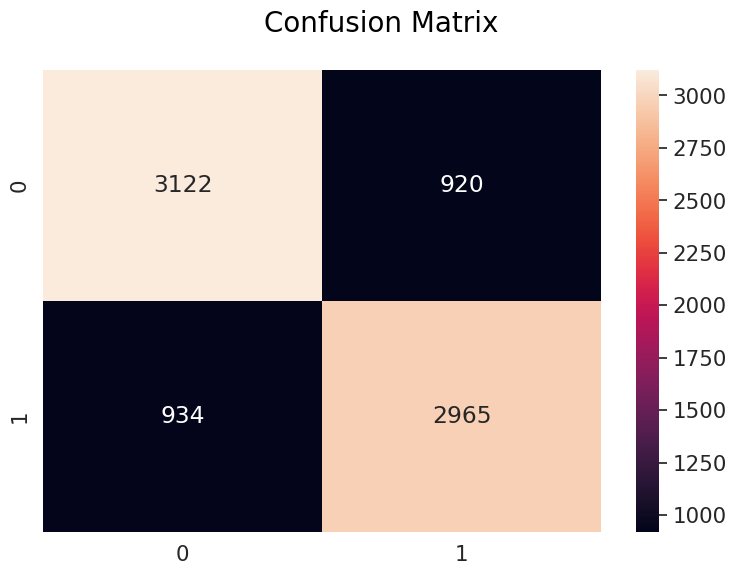

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Make predictions from the validation set
y_predict = model.predict(X_validation)

# Create a confusion matrix with the validation labels and our model's predictions
conf_matrix = confusion_matrix(y_validation, y_predict)

# Plot confusion matrix
df_conf_matrix = pd.DataFrame(conf_matrix, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (9,6))
plt.suptitle("Confusion Matrix", fontsize=20)
sn.set(font_scale=1.4)
sn.heatmap(df_conf_matrix, annot=True, fmt='g')

# Display scores
print(f"Accuracy Score:  {accuracy_score(y_validation, y_predict):.5f}")  # NumCorrectPredicts / TotalNumPredicts
print(f"Precision Score: {precision_score(y_validation, y_predict):.5f}") # TP / (TP + FP)
print(f"Recall Score:    {recall_score(y_validation, y_predict):.5f}")    # TP / (TP + FN)
print(f"F1 Score:        {f1_score(y_validation, y_predict):.5f}")        # 2 * (precision * recall) / (precision + recall)

### K-Fold Cross Validation

Estimate how well the model is likely to generalize to unseen data

In [12]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

print("Cross Validated Scores Mean: %0.5f Std: (+/- %0.5f)" % (accuracies.mean(), accuracies.std() * 2))

Cross Validated Scores Mean: 0.76766 Std: (+/- 0.00951)


## Model Tuning

### Grid Search: Round One

In [13]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
parameter_grid = {
    # Select regularization methods
    'penalty': ['l1', 'l2'],
    # Create regularization hyperparameter space
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    # Specify the solvers to be tuned
    'solver': ['saga'], 
}

grid_search = GridSearchCV(estimator = model,
                           param_grid = parameter_grid,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
start_time = time.time()
grid_search = grid_search.fit(X_train, y_train)
end_time = time.time()

rf_best_accuracy1 = grid_search.best_score_
rf_best_parameters1 = grid_search.best_params_

print("Round One Time: %0.2f seconds" % (end_time - start_time))
print(f"Round One Best Accuracy: {rf_best_accuracy1:.6f}")
print("Round One Best Hyperparameters:", rf_best_parameters1)

Round One Time: 9.70 seconds
Round One Best Accuracy: 0.767506
Round One Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}


### Grid Search: Round Two

In [14]:
# Define the hyperparameter grid
parameter_grid = {
    # Select regularization methods
    'penalty': ['l1'],
    # Create regularization hyperparameter space
    'C': [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2],
    # Specify the solvers to be tuned
    'solver': ['saga'] 
}

grid_search = GridSearchCV(estimator = model,
                           param_grid = parameter_grid,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
start_time = time.time()
grid_search = grid_search.fit(X_train, y_train)
end_time = time.time()

rf_best_accuracy2 = grid_search.best_score_
rf_best_parameters2 = grid_search.best_params_

print("Round Two Time: %0.2f seconds" % (end_time - start_time))
print(f"Round Two Best Accuracy: {rf_best_accuracy2:.6f}")
print("Round Two Best Hyperparameters:", rf_best_parameters2)

Round Two Time: 5.45 seconds
Round Two Best Accuracy: 0.767664
Round Two Best Hyperparameters: {'C': 0.05, 'penalty': 'l1', 'solver': 'saga'}


### Analyze Coefficients

In [15]:
# Analyze model coefficients
df_coefficients = pd.concat([pd.DataFrame(X_train.columns, columns = ['features']),
           pd.DataFrame(np.transpose(model.coef_), columns = ['coef'])
           ],axis = 1)

# Display (adjust as needed)
df_coefficients.head()

,features,coef
0,dayofweek,0.016889
1,hour,-0.014887
2,age,-0.137531
3,numscreens,-0.105133
4,minigame,-0.018644


Calculate **p-values** from our sklearn model: Perform permutation testing to approximate
(This may take some time)

In [16]:
from sklearn.utils import resample

# Number of permutations (adjust as needed)
n_permutations = 1000
# Flatten the coefficient array
coefs = model.coef_.ravel()  
# Create an array to store permuted coefficients
permuted_coefs = np.zeros((n_permutations, len(coefs)))

# Perform permutation testing
for i in range(n_permutations):
    # Resample the feature matrix while keeping the target variable unchanged
    X_permuted = resample(X_train)
    # Fit the logistic regression model on the permuted data
    model.fit(X_permuted, y_train)
    # Record the permuted coefficients in the permuted_coefs array
    permuted_coefs[i] = model.coef_.ravel()

# Calculate the p-values
p_values = np.mean(np.abs(permuted_coefs) >= np.abs(coefs), axis=0)

# Add the p-values to the coefficient DataFrame
df_coefficients['p-value'] = p_values

In [17]:
# Display p-values (adjust as needed)
df_coefficients.head()

,features,coef,p-value
0,dayofweek,0.016889,0.102
1,hour,-0.014887,0.131
2,age,-0.137531,0.000
3,numscreens,-0.105133,0.000
4,minigame,-0.018644,0.065


## Final Model Training

In [18]:
# Concatenate the training and validation feature datasets vertically
X_train = pd.concat([X_train, X_validation], axis=0).reset_index(drop=True)

# Concatenate the training and validation label datasets vertically
y_train = pd.concat([y_train, y_validation], axis=0).reset_index(drop=True)

model.fit(X_train, y_train)

LogisticRegression(C=0.05, penalty='l1', random_state=42, solver='saga')

## Final Model Evaluation

Accuracy Score:  0.77322
Precision Score: 0.77163
Recall Score:    0.77951
F1 Score:        0.77555


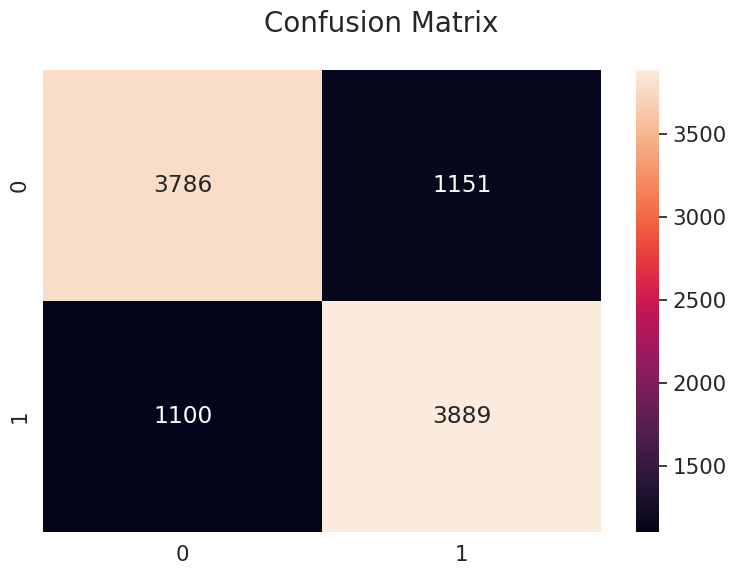

In [19]:
# Make predictions from the test set
y_predict = model.predict(X_test)

# Create a confusion matrix with test labels and our model's predictions
conf_matrix = confusion_matrix(y_test, y_predict)

# Plot confusion matrix
df_conf_matrix = pd.DataFrame(conf_matrix, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (9,6))
plt.suptitle("Confusion Matrix", fontsize=20)
sn.set(font_scale=1.4)
sn.heatmap(df_conf_matrix, annot=True, fmt='g')

# Display scores
print(f"Accuracy Score:  {accuracy_score(y_test, y_predict):.5f}")  # NumCorrectPredicts / TotalNumPredicts
print(f"Precision Score: {precision_score(y_test, y_predict):.5f}") # TP / (TP + FP)
print(f"Recall Score:    {recall_score(y_test, y_predict):.5f}")    # TP / (TP + FN)
print(f"F1 Score:        {f1_score(y_test, y_predict):.5f}")        # 2 * (precision * recall) / (precision + recall)

In [20]:
# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

print("Cross Validated Scores Mean: %0.5f Std: (+/- %0.5f)" % (accuracies.mean(), accuracies.std() * 2))

Cross Validated Scores Mean: 0.76759 Std: (+/- 0.00818)


## Save Model

In [21]:
import pickle

# Create a directory to save the model if it doesn't exist
directory = "../models"
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the model to the specified directory
filename = os.path.join(directory, 'sklearn_model.pkl')
with open(filename, 'wb') as file:
    pickle.dump(model, file)

## Format Results

Here we format the final results from our model's predictions to the user this data came from. Though in the future we will not have 'enrolled' data for the deployed model's predictions, a similar process can be utilized. This enables the sales team to identify users the model has estimated unlikely to subscribe to paid subscriptions. 

In [22]:
# Concatenate test labels to the user they came from
final_results = pd.concat([y_test, test_identifier], axis =1).dropna()
# Add predicted results from the model
final_results['predicted_results'] = y_predict
final_results = final_results[['user', 'enrolled', 'predicted_results']].reset_index(drop=True)

# Display (adjust as needed)
final_results.head(10)

,user,enrolled,predicted_results
0,282372,1,1
1,355818,1,0
2,338666,1,1
3,269942,1,1
4,18305,0,0
5,181631,0,0
6,99580,0,1
7,214036,0,0
8,136307,0,0
9,126790,1,1


### Save Results 

Persist final results and a list of users our model has estimated to be unlikely to enroll in the paid subscription

In [23]:
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table
from datetime import datetime
import csv

# Create a directory to save results if it doesn't exist
directory = "../data/results"
if not os.path.exists(directory):
    os.makedirs(directory)

# Get the current date and time, remove milliseconds
datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Save final results to a .csv file 
final_results.to_csv(f"../data/results/final_results_{datetime}.csv")

# Filter the DataFrame for a list of users unlikely to subscribe
final_results = final_results[final_results.predicted_results == 0].copy()
unlikely_to_subscribe = final_results.copy().drop(columns = ['enrolled', 'predicted_results'])

# Save the list of users unlikely to subscribe to a .csv file
unlikely_to_subscribe.to_csv(f"../data/results/users_unlikely_to_subscribe_{datetime}.csv")

# Define paths to convert
csv_file = f"../data/results/users_unlikely_to_subscribe_{datetime}.csv"
pdf_file = f"../data/results/users_unlikely_to_subscribe_{datetime}.pdf"

# Convert the .csv file 
data = []
with open(csv_file, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        data.append(row)

# Create a PDF document
doc = SimpleDocTemplate(pdf_file, pagesize=letter)

# Create a table from the CSV data
table = Table(data)

# Add the table to the document
doc.build([table])